In [4]:
%matplotlib inline
import numpy as np
np.random.seed(2014)
import matplotlib.pyplot as plt

import dipy.data as dpd
import dipy.reconst.cross_validation as xval
import dipy.reconst.dti as dti
import dipy.reconst.csdeconv as csd
import scipy.stats as stats

In [ ]:
dpd.fetch_stanford_hardi()
img, gtab = dpd.read_stanford_hardi()
data = img.get_data()

cc_vox = data[40, 70, 38]
cso_vox = data[30, 76, 38]

In [ ]:
dti_model = dti.TensorModel(gtab)
response, ratio = csd.auto_response(gtab, data, roi_radius=10, fa_thr=0.7)
csd_model = csd.ConstrainedSphericalDeconvModel(gtab, response)

In [ ]:
dti_cc = xval.kfold_xval(dti_model, cc_vox, 2)
csd_cc = xval.kfold_xval(csd_model, cc_vox, 2, response)
dti_cso = xval.kfold_xval(dti_model, cso_vox, 2)
csd_cso = xval.kfold_xval(csd_model, cso_vox, 2, response)

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches([12,6])
ax[0].plot(cc_vox[~gtab.b0s_mask], dti_cc[~gtab.b0s_mask], 'o', color='b')
ax[0].plot(cc_vox[~gtab.b0s_mask], csd_cc[~gtab.b0s_mask], 'o', color='r')
ax[1].plot(cso_vox[~gtab.b0s_mask], dti_cso[~gtab.b0s_mask], 'o', color='b', label='DTI')
ax[1].plot(cso_vox[~gtab.b0s_mask], csd_cso[~gtab.b0s_mask], 'o', color='r', label='CSD')
plt.legend(loc='upper left')
for this_ax in ax:
    this_ax.set_xlabel('Data (relative to S0)')
    this_ax.set_ylabel('Model prediction (relative to S0)')
fig.savefig("model_predictions.png")

plt.show()

In [ ]:
cc_dti_r2=stats.pearsonr(cc_vox[~gtab.b0s_mask], dti_cc[~gtab.b0s_mask])[0]**2
cc_csd_r2=stats.pearsonr(cc_vox[~gtab.b0s_mask], csd_cc[~gtab.b0s_mask])[0]**2
cso_dti_r2=stats.pearsonr(cso_vox[~gtab.b0s_mask], dti_cso[~gtab.b0s_mask])[0]**2
cso_csd_r2=stats.pearsonr(cso_vox[~gtab.b0s_mask], csd_cso[~gtab.b0s_mask])[0]**2

print("Corpus callosum\n"
      "DTI R2 : %s\n"
      "CSD R2 : %s\n"
      "\n"
      "Centrum Semiovale\n"
      "DTI R2 : %s\n"
      "CSD R2 : %s\n" % (cc_dti_r2, cc_csd_r2, cso_dti_r2, cso_csd_r2))

In [ ]:
outdir='/media/DiskArray/shared_data/js/bbc/defunct_data/test_dwi_out'
import os
os.chdir(outdir)
from dipy.viz import fvtk
ren = fvtk.ren()
ren.SetBackground(1, 1, 1)
colors_b2000 = fvtk.colors.blue * np.ones(gtab.bvecs.shape)
fvtk.add(ren, fvtk.point(gtab.gradients, colors_b2000, point_radius=100))
print('Saving illustration as stanford_hardi_gradients2.png')
fvtk.record(ren, out_path='stanford_hardi_gradients2.png', size=(300, 300))
fvtk.show(ren)

Mid Corpus callosum: x=73-74, y=99-100, z=27-28
Centrum Semiovale: x=62-63, y=11-113, z=31-33

In [1]:
#shortcut skips masking and eddy. only does fitting
%matplotlib inline
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from dipy.denoise.noise_estimate import estimate_sigma
from time import time
from dipy.denoise.non_local_means import non_local_means
from dipy.denoise.adaptive_soft_matching import adaptive_soft_matching
from os.path import join
from dipy.core.gradients import gradient_table
from dipy.io import read_bvals_bvecs
from pylabs.utils.paths import getnetworkdataroot
fs = getnetworkdataroot()
#set up files post eddy
project = 'bbc'
subjid = [209]
fname_templ = 'sub-bbc{sid}_ses-{snum}_{meth}_{runnum}'
sespassqc = [1]
methodpassqc = ['dti_15dir_b1000']
runpassqc = [1]
dwi_fnames = [fname_templ.format(sid=str(s), snum=str(ses), meth=m, runnum=str(r)) for s, ses, m, r in zip(subjid, sespassqc, methodpassqc, runpassqc)]
#add for loop over dwi_fnames here:
dwi_fname = dwi_fnames[0]
fpath = join(fs, project, dwi_fname.split('_')[0] , dwi_fname.split('_')[1], 'dwi')
fdwi = join(fpath, dwi_fname + '.nii')
fbvecs = join(fpath, dwi_fname + '.bvecs')
fbvals = join(fpath, dwi_fname + '.bvals')
fbvecs_ec = join(fpath, dwi_fname + '_eddy_corrected.eddy_rotated_bvecs')
S0_fname = join(fpath, dwi_fname + '_S0.nii')
brain_outfname = S0_fname[: -6] + 'S0_brain'

bvals_ec, bvecs_ec = read_bvals_bvecs(fbvals, fbvecs_ec)
gtab_ec = gradient_table(bvals_ec, bvecs_ec)
img = nib.load(fdwi)
img_ec = nib.load(join(fpath, fdwi[:-4] + '_eddy_corrected.nii.gz'))
data_ec = img_ec.get_data()
mask_img = nib.load(brain_outfname + '_mask.nii')
mask = mask_img.get_data()

In [2]:
#CC_vox_209 = data_ec[73:75,99:101,27:29]
#CSO_vox_209 = data_ec[62:64, 111:114, 31:34]
CC_vox_209 = data_ec[73,99,27]
CSO_vox_209 = data_ec[62, 111, 31]


In [8]:
dti_model_209 = dti.TensorModel(gtab_ec)
response_209, ratio_209 = csd.auto_response(gtab_ec, data_ec, roi_radius=10, fa_thr=0.7)
csd_model_209 = csd.ConstrainedSphericalDeconvModel(gtab_ec, response_209)

In [9]:
dti_cc_209 = xval.kfold_xval(dti_model_209, CC_vox_209, 3)
csd_cc_209 = xval.kfold_xval(csd_model_209, CC_vox_209, 3, response_209)
dti_cso_209 = xval.kfold_xval(dti_model_209, CSO_vox_209, 3)
csd_cso_209 = xval.kfold_xval(csd_model_209, CSO_vox_209, 3, response_209)

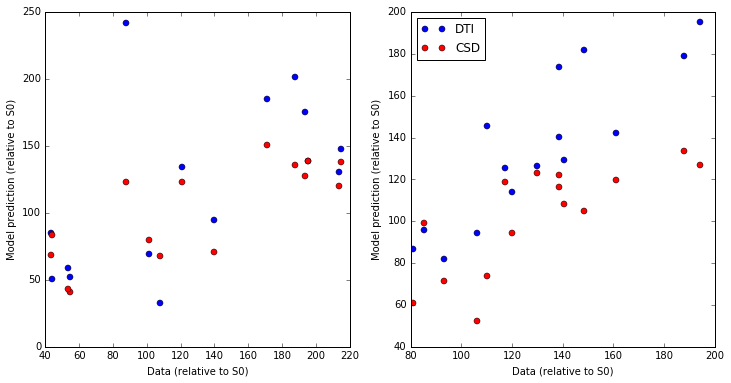

In [11]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches([12,6])
ax[0].plot(CC_vox_209[~gtab_ec.b0s_mask], dti_cc_209[~gtab_ec.b0s_mask], 'o', color='b')
ax[0].plot(CC_vox_209[~gtab_ec.b0s_mask], csd_cc_209[~gtab_ec.b0s_mask], 'o', color='r')
ax[1].plot(CSO_vox_209[~gtab_ec.b0s_mask], dti_cso_209[~gtab_ec.b0s_mask], 'o', color='b', label='DTI')
ax[1].plot(CSO_vox_209[~gtab_ec.b0s_mask], csd_cso_209[~gtab_ec.b0s_mask], 'o', color='r', label='CSD')
plt.legend(loc='upper left')
for this_ax in ax:
    this_ax.set_xlabel('Data (relative to S0)')
    this_ax.set_ylabel('Model prediction (relative to S0)')
fig.savefig("model_predictions.png")

plt.show()

In [12]:
dti_cc_209_r2=stats.pearsonr(CC_vox_209[~gtab_ec.b0s_mask], dti_cc_209[~gtab_ec.b0s_mask])[0]**2
csd_cc_209_r2=stats.pearsonr(CC_vox_209[~gtab_ec.b0s_mask], csd_cc_209[~gtab_ec.b0s_mask])[0]**2
dti_cso_209_r2=stats.pearsonr(CSO_vox_209[~gtab_ec.b0s_mask], dti_cso_209[~gtab_ec.b0s_mask])[0]**2
csd_cso_209_r2=stats.pearsonr(CSO_vox_209[~gtab_ec.b0s_mask], csd_cso_209[~gtab_ec.b0s_mask])[0]**2

print("Corpus callosum\n"
      "DTI R2 : %s\n"
      "CSD R2 : %s\n"
      "\n"
      "Centrum Semiovale\n"
      "DTI R2 : %s\n"
      "CSD R2 : %s\n" % (dti_cc_209_r2, csd_cc_209_r2, dti_cso_209_r2, csd_cso_209_r2))

Corpus callosum
DTI R2 : 0.322591092687
CSD R2 : 0.617425583494

Centrum Semiovale
DTI R2 : 0.758813673294
CSD R2 : 0.576137946997

